<a href="https://colab.research.google.com/github/ku-milab/DeepLearningTutorial/blob/master/TF1/ali_TF1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Adversarially Learned Inference
![대체 텍스트](https://ishmaelbelghazi.github.io/ALI/assets/ali_probabilistic.svg)

### Import TensorFlow and other libraries

In [0]:
# To generate GIFs
!pip -q install imageio

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

!pip -q install tensorflow-gpu==1.13.1
import tensorflow as tf

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio

from IPython import display

### Load and prepare the dataset

You will use the MNIST dataset to train the generator and the discriminator. The generator will generate handwritten digits resembling the MNIST data.

In [0]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

In [0]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')

# Normalizing the images to the range of [0., 1.]
train_images /= 255.
test_images /= 255.

# Binarization
train_images[train_images >= .5] = 1.
train_images[train_images < .5] = 0.
test_images[test_images >= .5] = 1.
test_images[test_images < .5] = 0.

## Create the models

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

### The Discriminator

The discriminator is a CNN-based image classifier.

In [0]:
class ALI:
  def __init__(self, noise_dim):
    self.noise_dim = noise_dim
    
    self.no_tied_bias = tf.get_variable(name="gen/nt_bias", shape=train_images.shape[1:], initializer=self._marg(x=train_images))
    
  def _marg(self, x):
    eps = 1e-7
    marg = np.clip(x.mean(axis=0)/255., eps, 1. - eps)
    marg = np.log(marg / (1. - marg))
    
    return tf.constant_initializer(marg, tf.float32)
    
  def generator_x(self, z):
    with tf.variable_scope("gen/x"):
      out = tf.layers.dense(inputs=z, units=7 * 7 * 256, use_bias=False)
      out = tf.layers.batch_normalization(inputs=out)
      out = tf.nn.leaky_relu(out)

      out = tf.reshape(out, shape=(-1, 7, 7, 256))

      out = tf.layers.conv2d_transpose(inputs=out, filters=128, kernel_size=5, strides=1, padding='same', use_bias=False)
      out = tf.layers.batch_normalization(inputs=out)
      out = tf.nn.leaky_relu(out)

      out = tf.layers.conv2d_transpose(inputs=out, filters=64, kernel_size=5, strides=2, padding='same', use_bias=False)
      out = tf.layers.batch_normalization(inputs=out)
      out = tf.nn.leaky_relu(out)

      out = tf.layers.conv2d_transpose(inputs=out, filters=1, kernel_size=5, strides=2, padding='same', use_bias=False, activation='tanh')
      
      out += self.no_tied_bias
      
      
    return out

  def generator_z(self, x):
    with tf.variable_scope("gen/z"):
      out = tf.layers.conv2d(inputs=x, filters=64, kernel_size=5, strides=2, padding='same')
      out = tf.nn.leaky_relu(out)
      out = tf.layers.dropout(inputs=out, rate=0.3)

      out = tf.layers.conv2d(inputs=out, filters=128, kernel_size=5, strides=2, padding='same')
      out = tf.nn.leaky_relu(out)
      out = tf.layers.dropout(inputs=out, rate=0.3)

      out = tf.layers.flatten(inputs=out)
      out = tf.layers.dense(inputs=out, units=self.noise_dim, activation="sigmoid")

    return out
  
  def discriminator_z(self, z):
    with tf.variable_scope("disc/z"):
      out = tf.layers.flatten(inputs=z)
      
      out = tf.layers.dense(inputs=out, units=self.noise_dim, use_bias=False)
      out = tf.layers.batch_normalization(inputs=out)
      out = tf.nn.leaky_relu(out)
      
      out = tf.layers.dense(inputs=z, units=self.noise_dim, use_bias=False)
      out = tf.layers.batch_normalization(inputs=out)
      out = tf.nn.leaky_relu(out)

    return out
  def discriminator_x(self, x):
    with tf.variable_scope("disc/x"):
      out = tf.layers.conv2d(inputs=x, filters=64, kernel_size=5, strides=2, padding='same')
      out = tf.nn.leaky_relu(out)
      out = tf.layers.dropout(inputs=out, rate=0.3)

      out = tf.layers.conv2d(inputs=out, filters=128, kernel_size=5, strides=2, padding='same')
      out = tf.nn.leaky_relu(out)
      out = tf.layers.dropout(inputs=out, rate=0.3)

      out = tf.layers.flatten(inputs=out)
      out = tf.layers.dense(inputs=out, units=self.noise_dim)
      out = tf.nn.leaky_relu(out)

    return out
  
  def discriminator_all(self, x, z):
    with tf.variable_scope("disc/all"):
      out = tf.concat((x, z), axis=-1)
      out = tf.layers.dense(inputs=out, units=self.noise_dim*2, use_bias=False)
      out = tf.layers.batch_normalization(inputs=out)
      out = tf.nn.leaky_relu(out)
      
      out = tf.layers.dense(inputs=out, units=self.noise_dim, use_bias=False)
      out = tf.layers.batch_normalization(inputs=out)
      out = tf.nn.leaky_relu(out)
      
      out = tf.layers.dense(inputs=out, units=1, use_bias=False, activation="sigmoid")

    return out

## Define the training loop

In [0]:
epochs = 5
batch_size = 100
noise_dim=100
num_examples_to_generate=16

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [7]:
model = ALI(noise_dim=noise_dim)

x_real = tf.placeholder(shape=(None, 28, 28, 1), dtype=tf.float32)
z_fake = tf.placeholder(shape=(None, noise_dim), dtype=tf.float32)


with tf.variable_scope("ali", reuse=False):
  z_real = model.generator_z(x=x_real)
  x_fake = model.generator_x(z=z_fake)
  
  concat_x = tf.concat((x_real, x_fake), axis=0)
  concat_disc_x = model.discriminator_x(x=concat_x)
  
  concat_z = tf.concat((z_real, z_fake), axis=0)
  concat_disc_z = model.discriminator_z(z=concat_z)
  
  concat_all = model.discriminator_all(x=concat_disc_x, z=concat_disc_z)

p_real, q_fake = tf.split(concat_all, 2, axis=0)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use keras.layers.conv2d_transpose instead.


## Define the loss and optimizers

Define loss functions and optimizers for both models.


### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the disciminator's predictions on real images to an array of 1s, and the disciminator's predictions on fake (generated) images to an array of 0s.

In [0]:
gen_loss = tf.reduce_mean(tf.nn.softplus(p_real) + tf.nn.softplus(-q_fake))
disc_loss = tf.reduce_mean(tf.nn.softplus(-p_real) + tf.nn.softplus(q_fake))

The discriminator and the generator optimizers are different since we will train two networks separately.

In [9]:
optimizer = tf.train.AdamOptimizer(1e-4)

disc_var = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="ali/disc")
gen_var = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="ali/gen")

print(gen_var)
print(disc_var)

[<tf.Variable 'ali/gen/z/conv2d/kernel:0' shape=(5, 5, 1, 64) dtype=float32_ref>, <tf.Variable 'ali/gen/z/conv2d/bias:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'ali/gen/z/conv2d_1/kernel:0' shape=(5, 5, 64, 128) dtype=float32_ref>, <tf.Variable 'ali/gen/z/conv2d_1/bias:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'ali/gen/z/dense/kernel:0' shape=(6272, 100) dtype=float32_ref>, <tf.Variable 'ali/gen/z/dense/bias:0' shape=(100,) dtype=float32_ref>, <tf.Variable 'ali/gen/x/dense/kernel:0' shape=(100, 12544) dtype=float32_ref>, <tf.Variable 'ali/gen/x/batch_normalization/gamma:0' shape=(12544,) dtype=float32_ref>, <tf.Variable 'ali/gen/x/batch_normalization/beta:0' shape=(12544,) dtype=float32_ref>, <tf.Variable 'ali/gen/x/conv2d_transpose/kernel:0' shape=(5, 5, 128, 256) dtype=float32_ref>, <tf.Variable 'ali/gen/x/batch_normalization_1/gamma:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'ali/gen/x/batch_normalization_1/beta:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'al

In [0]:
# with tf.control_dependencies(disc_bn):
disc_update = optimizer.minimize(disc_loss, var_list=disc_var)

# with tf.control_dependencies(gen_bn):
gen_update = optimizer.minimize(gen_loss, var_list=gen_var)

In [0]:
def generate_and_save_images(results, epoch):
  plt.figure(figsize=(4,4))
  for i in range(len(results)):
      plt.subplot(4, 4, i+1)
      plt.imshow(np.array(results[i, :, :, 0]), cmap='gray')
      plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [0]:
# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
noise_fixed = np.random.normal(size=[num_examples_to_generate, noise_dim])

In [0]:
def train(sess):
  noise_gen = sess.run(fetches=x_fake, feed_dict={z_fake: noise_fixed})
  generate_and_save_images(noise_gen, epoch=0)
  for epoch in range(1, epochs + 1):
    start_time = time.time()
    rand_idx = np.random.permutation(len(train_images))
    for step in range(0, len(rand_idx)-1, batch_size):
      cur_data = train_images[rand_idx[step:step+batch_size]]
      sess.run(fetches=[gen_update, disc_update], feed_dict={x_real: cur_data, z_fake: np.random.normal(size=[len(cur_data), noise_dim])})

    end_time = time.time()

    if epoch % 1 == 0:
      tst_gen_loss, tst_disc_loss = 0., 0.
      for tst_step in range(0, len(test_images)-num_examples_to_generate+1, num_examples_to_generate):
        cur_dat = test_images[tst_step: tst_step+num_examples_to_generate]
        gl, dl = sess.run(fetches=[gen_loss, disc_loss], feed_dict={x_real: cur_dat, z_fake: noise_fixed})
        tst_gen_loss += gl
        tst_disc_loss += dl

      tst_gen_loss/= len(test_images)
      tst_disc_loss /= len(test_images)

      print('Gen Loss {}, Disc Loss {} Time for epoch {} is {} sec'.format(tst_gen_loss, tst_disc_loss, epoch + 1, end_time - start_time))
      noise_gen = sess.run(fetches=x_fake, feed_dict={z_fake: noise_fixed})
      generate_and_save_images(noise_gen, epoch=0)

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

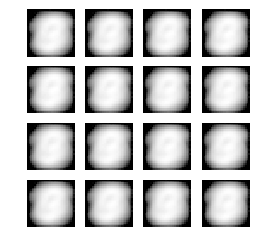

Gen Loss 0.12539942278861999, Disc Loss 0.06290096963644028 Time for epoch 2 is 15.065242528915405 sec


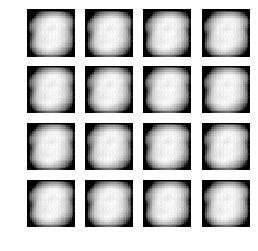

Gen Loss 0.12540018849372864, Disc Loss 0.06290068714618682 Time for epoch 3 is 14.52207636833191 sec


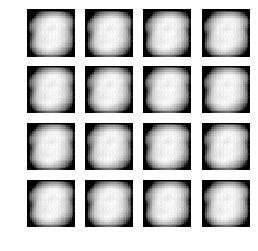

In [0]:
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  train(sess)

## Create a GIF


In [0]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info >= (6,2,0,''):
  display.Image(filename=anim_file)

If you're working in Colab you can download the animation with the code below:

In [0]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download(lite_model_path)